In [1]:
import os
from pathlib import Path
from pnpl.datasets.libribrain2025 import constants_utils

constants_utils.set_remote_constants_url(
    f"{(Path(os.getcwd()) / 'constants.json').as_uri()}")
constants_utils.refresh_constants();

## Before Averaging

In [2]:
from pnpl.datasets import LibriBrainPhoneme

train_dataset = LibriBrainPhoneme(
    data_path="./data/",
    tmin=0.0,
    tmax=0.5,
    standardize=True,
    partition="train",
)
validation_dataset = LibriBrainPhoneme(
    data_path="./data/",
    tmin=0.0,
    tmax=0.5,
    standardize=True,
    partition="validation",
)

In [3]:
import numpy as np


mean_diff = np.abs(train_dataset.channel_means - validation_dataset.channel_means)
std_diff = np.abs(train_dataset.channel_stds - validation_dataset.channel_stds)

In [4]:
mean_diff.mean().item(), mean_diff.std().item()

(1.6863284997267685e-13, 2.3835367102178217e-13)

In [5]:
std_diff.mean().item(), std_diff.std().item()

(6.129788977221137e-11, 8.191687132534478e-11)

## After Averaging

In [6]:
from pathlib import Path
from libribrain_experiments.grouped_dataset import MyGroupedDatasetV3
from typing import Literal
from pnpl.datasets import LibriBrainCompetitionHoldout, LibriBrainPhoneme

split: Literal["train", "val"] = "val"

raw_train_dataset = LibriBrainPhoneme(
    data_path="./data/",
    tmin=0.0,
    tmax=0.5,
    standardize=True,
    partition="train",
)
raw_validation_dataset = LibriBrainPhoneme(
    data_path="./data/",
    tmin=0.0,
    tmax=0.5,
    standardize=True,
    partition="validation",
    channel_means=raw_train_dataset.channel_means,
    channel_stds=raw_train_dataset.channel_stds,
)
source_dataset = MyGroupedDatasetV3(
    raw_train_dataset if split == "train" else raw_validation_dataset,
    grouped_samples=100,
    drop_remaining=False,
    average_grouped_samples=True,
    state_cache_path=Path(f"./data_preprocessed/groupedv3/{split}_grouped_100.pt"),
    balance=True,
    shuffle=True,
)

holdout_dataset = LibriBrainCompetitionHoldout(
    # channel_means=raw_train_dataset.channel_means,
    # channel_stds=raw_train_dataset.channel_stds,
    data_path="./data/",
    task="phoneme",
    tmin=0.0,
    tmax=0.5,
    standardize=False, # already standardized
)

In [7]:
print(f"Raw train means: {raw_train_dataset.channel_means.mean().item():.6e} ± {raw_train_dataset.channel_means.std().item():.6e}")
print(f"Raw train stds: {raw_train_dataset.channel_stds.mean().item():.6e} ± {raw_train_dataset.channel_stds.std().item():.6e}")

Raw train means: 1.072113e-15 ± 9.067206e-14
Raw train stds: 7.629011e-11 ± 8.890892e-11


In [8]:
from tqdm import tqdm
import numpy as np
from torch.utils.data import DataLoader

all_means = []
all_stds = []

source_loader = DataLoader(
    source_dataset, batch_size=256, shuffle=False, num_workers=4)

for sample, *_ in tqdm(source_loader):
    arr = sample.numpy()
    mean = arr.mean(axis=2)  # mean over time
    std = arr.std(axis=2)    # std over time
    all_means.extend(mean)
    all_stds.extend(std)

source_channel_means = np.mean(np.stack(all_means), axis=0)
source_channel_stds = np.mean(np.stack(all_stds), axis=0)

all_means = []
all_stds = []

holdout_loader = DataLoader(
    holdout_dataset, batch_size=256, shuffle=False, num_workers=4)

for sample in tqdm(holdout_loader):
    arr = sample.numpy()
    mean = arr.mean(axis=2)  # mean over time
    std = arr.std(axis=2)    # std over time
    all_means.extend(mean)
    all_stds.extend(std)

holdout_channel_means = np.mean(np.stack(all_means), axis=0)
holdout_channel_stds = np.mean(np.stack(all_stds), axis=0)

100%|██████████| 10/10 [00:00<00:00, 22.81it/s]


In [9]:
import numpy as np


mean_diff = np.abs(source_channel_means - holdout_channel_means)
std_diff = np.abs(source_channel_stds - holdout_channel_stds)

In [10]:
print(f"Source means: {source_channel_means.mean().item():.6f} ± {source_channel_means.std().item():.6f}")
print(f"Source stds: {source_channel_stds.mean().item():.6f} ± {source_channel_stds.std().item():.6f}")
print(f"Holdout means: {holdout_channel_means.mean().item():.6f} ± {holdout_channel_means.std().item():.6f}")
print(f"Holdout stds: {holdout_channel_stds.mean().item():.6f} ± {holdout_channel_stds.std().item():.6f}")

Source means: -0.000423 ± 0.004044
Source stds: 0.010626 ± 0.007590
Holdout means: -0.002820 ± 0.041547
Holdout stds: 0.499323 ± 0.205752


In [11]:
# mean_diff.mean().item(), mean_diff.std().item()
print(f"Mean diff: {mean_diff.mean().item():.6f} ± {mean_diff.std().item():.6f}")
print(f"Std diff: {std_diff.mean().item():.6f} ± {std_diff.std().item():.6f}")

Mean diff: 0.037168 ± 0.015913
Std diff: 0.488697 ± 0.204512


Text(0.5, 1.0, 'Channel Means Comparison')

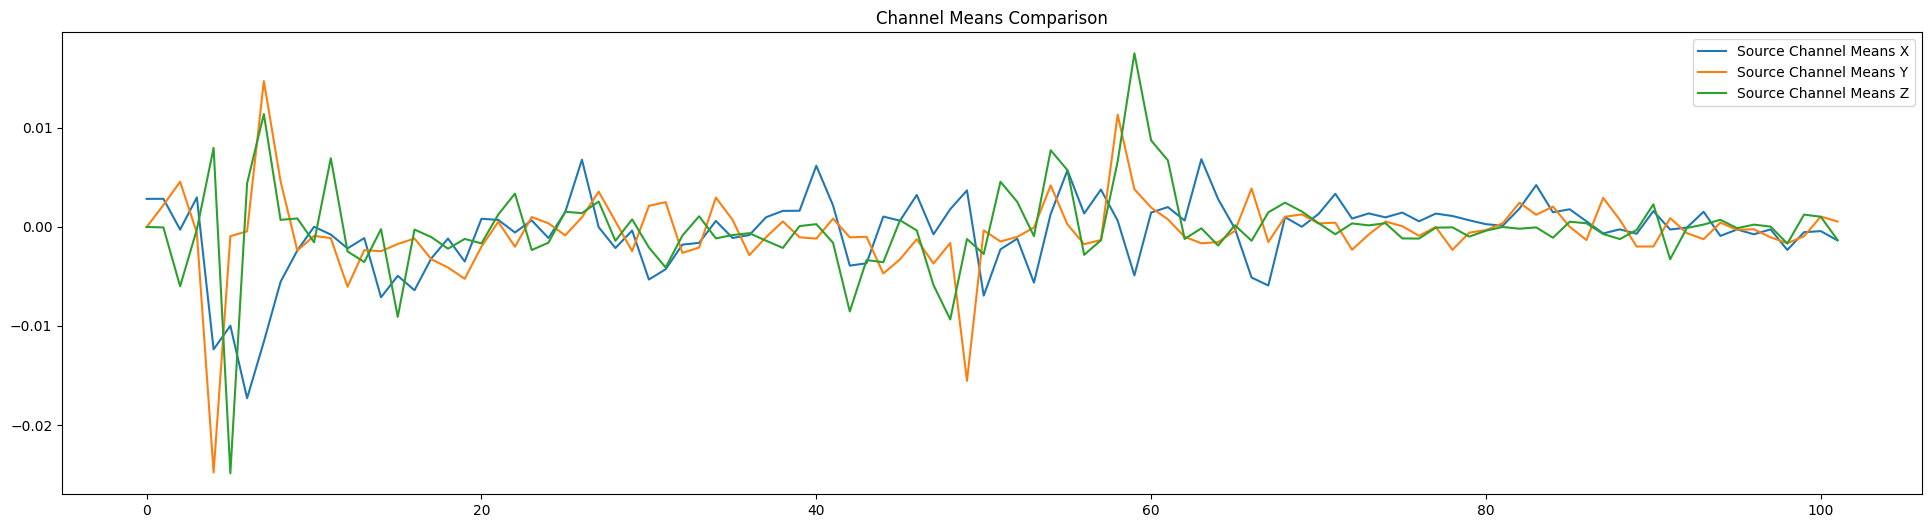

In [12]:
from matplotlib import pyplot as plt
plt.figure(figsize=(24, 6))
plt.plot(source_channel_means[0::3], label='Source Channel Means X')
plt.plot(source_channel_means[1::3], label='Source Channel Means Y')
plt.plot(source_channel_means[2::3], label='Source Channel Means Z')
# plt.plot(holdout_channel_means, label='Holdout Channel Means')
plt.legend()
plt.title('Channel Means Comparison')